In [1]:
import cv2
import matplotlib.pyplot as plt
import torch

from swinir.models.network_swinir import SwinIR
from utils.dataloader import get_dataloader
from utils.image_processing import denormalize, convert_y_channel, quantize

/home/lahj91/anaconda3/envs/SR/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:1')

In [3]:
model_swinir = SwinIR(upscale=2, img_size=(48,48), window_size=8, in_chans=3, img_range=1.,
               depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
               mlp_ratio=2, upsampler='pixelshuffle', resi_connection='1conv').to(device)
checkpoint = torch.load('swinir/weights/001_classicalSR_DIV2K_s48w8_SwinIR-M_x2.pth', map_location='cpu')

model_swinir.load_state_dict(checkpoint['params'])
model_swinir.eval()

SwinIR(
  (conv_first): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=180, input_resolution=(48, 48), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=180, input_resolution=(48, 48), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=180, window_size=(8, 8), num_heads=6
              (qkv): Linear(in_features=180, out_features=540, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=180, out_features=180, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
       

In [4]:
log_dir = 'logs/x2/20220816_1914/'
model_ours = torch.load(log_dir+'model/model.pt', map_location=device)
model_ours.load_state_dict(torch.load(log_dir+'state_dict/state_dict_epoch_3000.pt', map_location='cpu'))
model_ours.eval()

SRTransformer(
  (encoder_embedding_layer): EmbeddingLayer(
    (linear_embedding): Conv2d(3, 128, kernel_size=(2, 2), stride=(2, 2))
  )
  (reconstruction_block): ReconstructionBlock(
    (fc_layer1): Linear(in_features=128, out_features=512, bias=True)
    (activation_layer): GELU()
    (fc_layer2): Linear(in_features=512, out_features=12, bias=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention_layer): MultiHeadSelfAttentionLayer(
          (query_fc_layer): Linear(in_features=128, out_features=128, bias=True)
          (key_value_fc_layers): Linear(in_features=128, out_features=256, bias=True)
          (output_fc_layer): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (feed_forward_layer): PositionWiseFeedForwardLayer(
          (first_fc_layer): Linear(in_features=128, out_features=512, bias

In [13]:
dataloader_val = get_dataloader(batch_size=16,
                                setting="test",
                                augmentation=False,
                                num_workers=8,
                                data='DIV2K',
                                Matlab_mode=False)
val_size = len(dataloader_val.dataset)

In [14]:
def PSNR(A, B):
    diff=A-B
    diff = convert_y_channel(diff, add_bias=False, device=device)
    mse = (diff**2).mean(dim=(1,2))
    return (-10)*torch.log10(mse).sum()

base : 37.210052413169784
swin : inf
ours : inf
origin


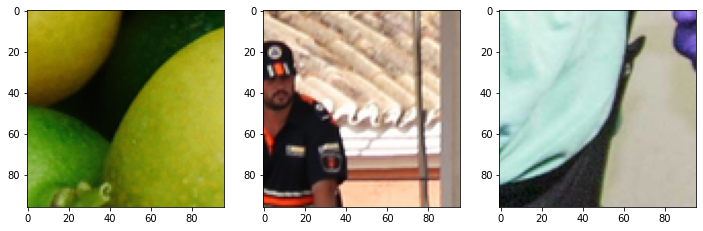

degraded


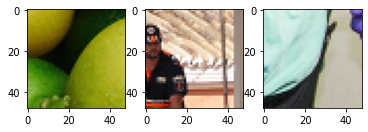

interpolated


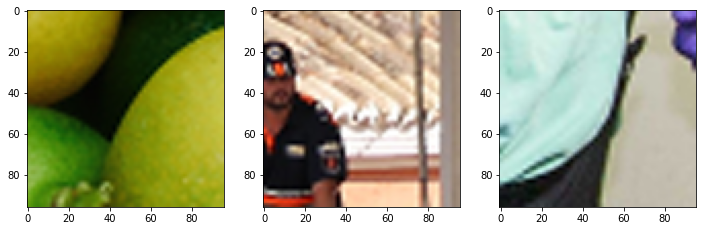

swinir


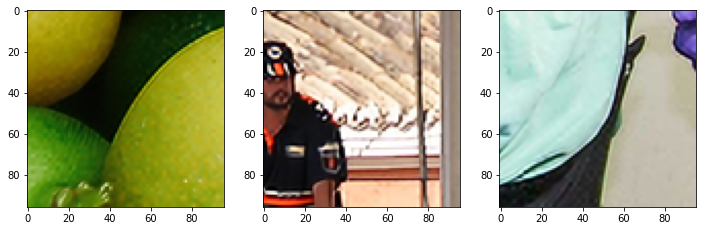

ours


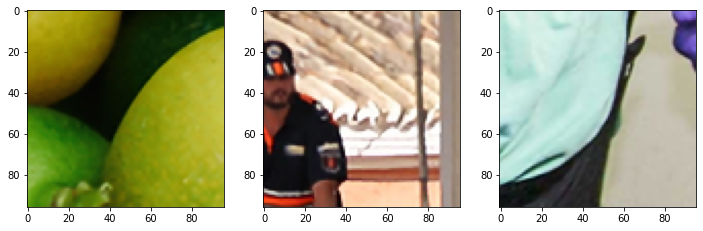

In [15]:
loss_swin = 0
loss_ours = 0
loss_base = 0

with torch.no_grad():
    for batch, items in enumerate(dataloader_val):
        n_batch = items['origin'].size()[0]

        origin = items['origin'].to(device)
        degraded=items['degraded'].to(device)
        interpolated=items['interpolated'].to(device)

        swin_result = model_swinir(denormalize(degraded, device=device))
        swin_result = quantize(swin_result)
        loss_swin += PSNR(swin_result, origin).item()
        
        our_result = model_ours(degraded, interpolated)
        our_result = quantize(denormalize(our_result, device=device))
        loss_ours += PSNR(our_result, origin).item()

        # Baseline evaluation error with interpolated images
        interpolated = denormalize(interpolated, device=device)
        loss_base += PSNR(interpolated, origin).item()

    # Log summaries.
    loss_swin /= val_size
    loss_ours /= val_size
    loss_base /= val_size
    
    print('base :', loss_base)
    print('swin :', loss_swin)
    print('ours :', loss_ours)
    
    print('origin')
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    for i, orig in enumerate(origin):
        ax[i].imshow(orig.permute(1,2,0).cpu().numpy()[:,:,::-1])
    plt.show()
    
    print('degraded')
    fig, ax = plt.subplots(1, 3, figsize=(6,2.5))
    for i, deg in enumerate(denormalize(degraded, device=device)):
        ax[i].imshow(deg.permute(1,2,0).cpu().numpy()[:,:,::-1])
    plt.show()

    print('interpolated')
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    for i, intp in enumerate(interpolated):
        ax[i].imshow(intp.permute(1,2,0).cpu().numpy()[:,:,::-1])
    plt.show()

    print('swinir')
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    for i, _swin in enumerate(swin_result):
        ax[i].imshow(_swin.permute(1,2,0).cpu().numpy()[:,:,::-1])
    plt.show()

    print('ours')
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    for i, _ours in enumerate(our_result):
        ax[i].imshow(_ours.permute(1,2,0).cpu().numpy()[:,:,::-1])
    plt.show()